<a href="https://colab.research.google.com/github/NiallJeffrey/MomentNetworks/blob/master/MomentNetwork_100dim/moment_network_100D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Make network estimate 2 parameter mean, variance and covariance as a function of numer of training data

# Load modules

In [3]:
!pip install emcee getdist
!pip install chainconsumer
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super 

     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 747kB 8.2MB/s 
  Created wheel for getdist: filename=GetDist-1.1.2-cp36-none-any.whl size=197663 sha256=a111d67dc1a60dd6425490fd61c8fd7a5e51ac76adcdeb916013d3bc3b1842cd
  Stored in directory: /root/.cache/pip/wheels/3f/b5/8a/e3d4221e66472ed329545d7026cec59dfd379256ca42692877
Successfully built getdist
     |████████████████████████████████| 51kB 4.8MB/s 
  Created wheel for chainconsumer: filename=ChainConsumer-0.32.0-cp36-none-any.whl size=42349 sha256=5535ddcdd2df64fd70d67860217eeed00c9cdad342a5ee6eb29b7228a7a315bc
  Stored in directory: /root/.cache/pip/wheels/66/dc/28/ad514ae6bc9dd12c4080b75d76b302145605bb008c24476d85
Successfully built chainconsumer
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgy

In [6]:
!pip install 'git+https://github.com/NiallJeffrey/MomentNetworks.git'

  Cloning https://github.com/NiallJeffrey/MomentNetworks.git to /tmp/pip-req-build-rsrhhu2c
  Running command git clone -q https://github.com/NiallJeffrey/MomentNetworks.git /tmp/pip-req-build-rsrhhu2c
  Created wheel for momentnetworks: filename=momentnetworks-0.1-cp36-none-any.whl size=3104 sha256=f684f4ba2fd0c85357c486f9126ddfa4c6367c002ad567d1ede1284632c32612
  Stored in directory: /tmp/pip-ephem-wheel-cache-pe8rn30e/wheels/d5/90/42/833efe39b17eb037678ff241c8946e912987034b18c69e2813
Successfully built momentnetworks


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gc
import numpy as np
from momentnetworks import demo
import os, sys
import random
import emcee as mc
import getdist
from google.colab import files
from getdist import plots, MCSamples
import time

In [8]:
n_training = 80000
size=100

training_z, cov_signal, cov_signal_inv = demo.generate__signal(size, n_training)

/usr/local/lib/python3.6/dist-packages/momentnetworks/demo.py:33: RuntimeWarning: covariance is not positive-semidefinite.
  training_z = np.random.multivariate_normal(np.zeros(size),cov_signal,n_training)


In [9]:
cov_noise = np.identity(size)*4
cov_noise_inv = np.linalg.pinv(cov_noise)
training_data = training_z +  np.random.multivariate_normal(np.zeros(size),cov_noise,n_training)

training_z_obs = [0.014, 0.996, 0.865, -0.25, 0.591, -0.104, 1.376, 1.022, 0.901, 0.835, 0.602, -0.157, -0.398, 0.483, -0.498, -1.437, -0.194, -0.535, -1.487, -1.103, -0.804, -0.741, -2.356, -0.235, -0.377, -0.081, 0.407, 0.777, 1.065, 0.959, 0.604, 2.419, 1.796, 1.261, 0.352, 1.648, 1.197, 0.782, 1.352, 1.61, 1.166, 0.497, 0.407, 0.737, 0.375, -0.484, 1.102, 1.316, 0.607, 1.3, 1.173, -0.642, -0.421, 0.53, 0.918, 1.763, 0.936, 1.27, 1.421, 1.757, 0.264, -0.061, 0.161, -0.033, 0.783, 0.533, 0.98, 0.509, 0.363, -1.247, -0.803, 0.065, -0.025, -0.073, 0.241, -0.744, 0.153, -0.711, 0.645, -0.539, -0.37, -0.748, -0.558, -0.188, 0.068, -0.524, -0.882, -0.367, -0.424, -0.93, -1.455, -2.157, -2.84, -0.588, -2.276, 0.246, -0.958, -0.591, 0.14, 0.156]
training_data_obs = [-1.607, 3.04, -0.357, -1.089, 2.622, -1.42, 4.596, -0.384, 4.087, -1.155, 1.745, -0.054, -3.418, -1.398, 1.598, 2.363, -1.018, -0.183, -1.317, -0.787, -0.046, 0.762, -4.387, 2.829, 2.406, 0.452, -0.132, -3.245, -1.389, 0.862, -0.146, -1.218, -0.634, 0.22, 2.792, 5.549, 5.298, 1.558, -2.26, -0.169, 2.297, 0.402, 0.644, 1.033, 3.076, -1.034, -3.227, 3.307, 0.463, 2.226, 2.847, 1.456, 1.012, 2.702, 2.812, 6.682, -1.643, 0.749, 2.727, 3.234, 0.139, 0.077, -0.899, 1.283, 3.093, -0.528, 2.225, 2.873, 1.314, -0.133, -1.184, 1.331, 1.148, 3.614, -0.678, 0.146, 1.136, -3.905, 0.178, 2.195, -0.533, -2.579, -1.13, -5.215, 2.584, 0.939, 0.083, -0.946, -0.288, -1.261, -1.456, -5.345, -0.291, 0.373, 0.689, 2.976, -3.337, 0.945, -0.807, -0.796]

training_z = training_z[1:]
training_data = training_data[1:]

# Do MCMC

In [10]:
n_dim=size
n_burn=5000
n_steps = 50000
n_walkers = 2 * n_dim

sampler_likelihood = mc.EnsembleSampler(n_walkers, n_dim, demo.log_posterior_likelihood,
                             args=(training_data_obs,cov_signal_inv,cov_noise_inv,))

In [11]:
theta_expected_mean = [0.1]*size
theta0 = np.array([list(demo.initial_parameters(theta_expected_mean, 1)) for i in range(n_walkers)])

In [12]:
t = time.time()
_ =sampler_likelihood.run_mcmc(theta0, n_steps) 

flat_samples_likelihood = sampler_likelihood.get_chain(discard=n_burn, flat=True,thin=3)

flat_samples_likelihood = np.array(flat_samples_likelihood[:,:2],dtype=np.float32)
gc.collect()

22

Removed no burn in


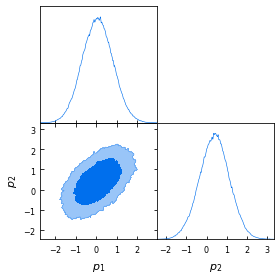

In [13]:
samples2 = MCSamples(samples=flat_samples_likelihood[:,:2],label='lik')

g = plots.get_subplot_plotter()
g.triangle_plot([samples2], filled=True)

In [14]:
np.cov(flat_samples_likelihood[:,0],flat_samples_likelihood[:,1])

array([[0.54477657, 0.29098884],
       [0.29098884, 0.54433363]])

# Moment network

In [ ]:
class simple_leaky():
    """
    A simple MLP with LeakyReLU activation
    """
    
    def __init__(self, input_size, output_size, learning_rate=None):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.output_size = output_size
        
    def model(self):
        print(self.input_size)
        
        input_data = (Input(shape=(self.input_size,)))

        x1 = Dense(self.input_size, input_dim=self.input_size, kernel_initializer='normal')(input_data)
        x1 = LeakyReLU(alpha=0.1)(x1)
        x2 = Dense(self.input_size*2, kernel_initializer='normal')(x1)
        x2 = LeakyReLU(alpha=0.1)(x2)
        x3 = Dense(self.input_size, kernel_initializer='normal')(x2)
        x3 = LeakyReLU(alpha=0.1)(x3)
        x4 = Dense(self.output_size, kernel_initializer='normal')(x3)
        

        dense_model = Model(input_data, x4)
        dense_model.summary()

        if self.learning_rate is None:
            dense_model.compile(optimizer='adam', loss='mse')
        else:
            dense_model.compile(optimizer=optimizers.Adam(lr=self.learning_rate), loss='mse')

        return dense_model

validation_index = np.int(n_training * 0.8)

In [ ]:
gc.collect()

13506

In [ ]:
model_instance = simple_leaky(size,2, learning_rate=1e-4)
regression = model_instance.model()

100
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 100)          

In [ ]:
history = regression.fit(training_data[:validation_index],
                               training_z[:validation_index,:2],
                               epochs =7,batch_size =50, shuffle=True,
                               validation_data = (training_data[validation_index:],
                               training_z[validation_index:,:2]))

Epoch 1/7
1280/1280 [==============================] - 2s 2ms/step - loss: 0.6273 - val_loss: 0.5570
Epoch 2/7
1280/1280 [==============================] - 2s 2ms/step - loss: 0.5493 - val_loss: 0.5510
Epoch 3/7
1280/1280 [==============================] - 2s 2ms/step - loss: 0.5417 - val_loss: 0.5487
Epoch 4/7
1280/1280 [==============================] - 2s 2ms/step - loss: 0.5372 - val_loss: 0.5480
Epoch 5/7
1280/1280 [==============================] - 2s 2ms/step - loss: 0.5334 - val_loss: 0.5489
Epoch 6/7
1280/1280 [==============================] - 2s 2ms/step - loss: 0.5298 - val_loss: 0.5500
Epoch 7/7
1280/1280 [==============================] - 2s 2ms/step - loss: 0.5265 - val_loss: 0.5528


In [ ]:
predicted_mean = regression.predict(np.atleast_2d(training_data))
predicted_mean_obs = regression.predict(np.atleast_2d(training_data_obs))

In [ ]:
training_var_unknown_mean = (training_z[:,:2]-regression.predict(np.atleast_2d(training_data)))**2.
training_var_unknown_mean = np.hstack([training_var_unknown_mean,
                                      np.atleast_2d((training_z[:,0]-regression.predict(np.atleast_2d(training_data))[:,0])*
                                      (training_z[:,1]-regression.predict(np.atleast_2d(training_data))[:,1])).T])
training_var_unknown_mean.shape

(79999, 3)

In [ ]:
model_instance = simple_leaky(size,3, learning_rate=1e-4)
regression_var_unknown_mean = model_instance.model()

100
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               20200     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               20100     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 100)          

In [ ]:
history = regression_var_unknown_mean.fit(training_data[:validation_index],
                               training_var_unknown_mean[:validation_index,:3],
                               epochs =5,batch_size =50, shuffle=True,
                               validation_data = (training_data[validation_index:],
                               training_var_unknown_mean[validation_index:,:3]))

Epoch 1/5
1280/1280 [==============================] - 2s 2ms/step - loss: 0.4890 - val_loss: 0.5309
Epoch 2/5
1280/1280 [==============================] - 2s 2ms/step - loss: 0.4810 - val_loss: 0.5300
Epoch 3/5
1280/1280 [==============================] - 2s 2ms/step - loss: 0.4787 - val_loss: 0.5288
Epoch 4/5
1280/1280 [==============================] - 2s 2ms/step - loss: 0.4764 - val_loss: 0.5294
Epoch 5/5
1280/1280 [==============================] - 2s 2ms/step - loss: 0.4740 - val_loss: 0.5316


In [ ]:
t = time.time()
predicted_var_obs = (regression_var_unknown_mean.predict(np.atleast_2d(training_data_obs[:]))[0])
print(time.time() - t)
print(predicted_var_obs)

0.06843876838684082
[0.5991414  0.6721985  0.36777443]


In [ ]:
likelihood_param_cov = np.cov(flat_samples_likelihood[:,0],flat_samples_likelihood[:,1])

In [ ]:
moment_network_param_cov = np.copy(likelihood_param_cov)
moment_network_param_cov[0,0] = predicted_var_obs[0]
moment_network_param_cov[1,1] = predicted_var_obs[1]
moment_network_param_cov[0,1] = predicted_var_obs[2]
moment_network_param_cov[1,0] = predicted_var_obs[2]

In [ ]:
moment_network_samples = np.array(np.random.multivariate_normal(predicted_mean_obs[0],moment_network_param_cov,int(1e6)),dtype=np.float32)
gc.collect()

4385

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

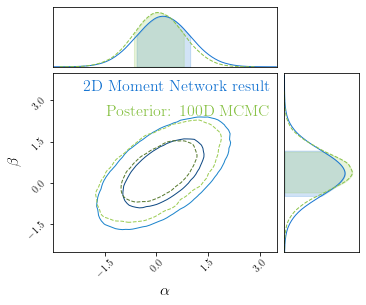

In [ ]:
c = ChainConsumer()

c.add_chain(moment_network_samples,
            parameters=[r'$\alpha$', r'$\beta$'],
            name = '2D Moment Network result', color_params='C1')


c.add_chain(flat_samples_likelihood[:,:2],
            parameters=[r'$\alpha$', r'$\beta$'],
            name = 'Posterior: 100D MCMC', linestyle='--')

c.configure(kde=[1.,None],sigmas = [1,2],
            contour_label_font_size = 11,
            label_font_size = 16, shade = False) 

fig = c.plotter.plot(figsize = (5,4), extents=[[-3.,3.5],[-2.5,4]], filename='marginal_moments.pdf')
files.download('marginal_moments.pdf')

Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x324 with 0 Axes>

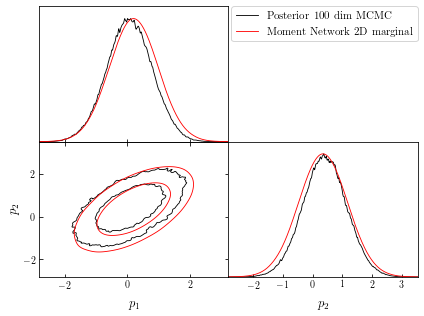

In [ ]:
samples2 = MCSamples(samples=flat_samples_likelihood[:,:2],label='Posterior 100 dim MCMC')
samples_moment = MCSamples(samples=moment_network_samples,label='Moment Network 2D marginal')

g = plots.get_single_plotter(width_inch=6)

g.triangle_plot([samples2, samples_moment], filled=False )
plt.savefig('test.png', dpi=300)
files.download('test.png')